In [1]:
# %matplotlib qt
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
path = '../data_library/mers/SerialIntervalEstimates-2.csv'
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T
serial_intervals = list(serial_intervals[0])[1:]

In [3]:
# Read MERS data
path = '../data_library/mers/MERSData.csv'
data = pd.read_csv(path)

# Switch the first day data to imported
# This step was performed in the original paper
data.iloc[0, 1] = 0
data.iloc[0, 2] = 1

In [4]:
# R_t inference, same as COVID notebooks
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

locally_infected_cases = data['Incidence Number']
imported_cases = data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

# Same inference, but using the LocImpBranchProPosterior
tau = 27
R_t_start = tau+1
a = 1
b = 0.2

prior_dist = scipy.stats.gamma(a, scale=1/b)
median = prior_dist.median()

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
sparse_epsilon_range = [0.25, 1.0, 2.0]

inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

all_intervals = []
all_df = pd.DataFrame(columns=column_names)
for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    
    intervals['Epsilon'] = [epsilon] * len(intervals.index)
    all_intervals.append(intervals)
    all_df = all_df.append(intervals)
    
inference_times = sorted(list(set(intervals['Time Points'].tolist())))

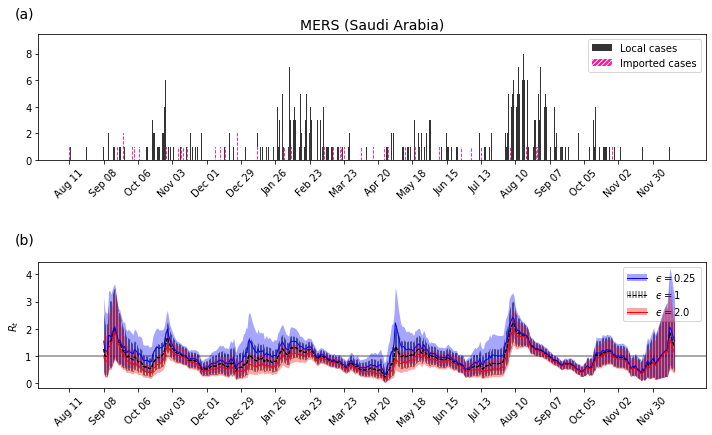

In [5]:
sparse_epsilon_range = [0.25, 1.0, 2.0]

fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2014, 8, 11),
    ['MERS (Saudi Arabia)',],
    [locally_infected_cases,],
    [imported_cases],
    datetime.datetime(2014, 8, 11) + datetime.timedelta(days=inference_times[0]-1),
    list(sparse_epsilon_range),
    [[all_intervals[epsilon_range.index(e)] for e in sparse_epsilon_range]],
    default_epsilon=1,
    show=False,
    mers=True)

fig.set_size_inches(10, 6)
axs = fig.get_axes()

axs[0].set_xticks([datetime.datetime(2014, 8, 11) + datetime.timedelta(days=int(i))
                  for i in range(len(locally_infected_cases))][::28])

axs[1].set_xticks([datetime.datetime(2014, 8, 11) + datetime.timedelta(days=int(i))
                      for i in range(len(locally_infected_cases))][::28])

plt.savefig('Figure_S6.pdf')

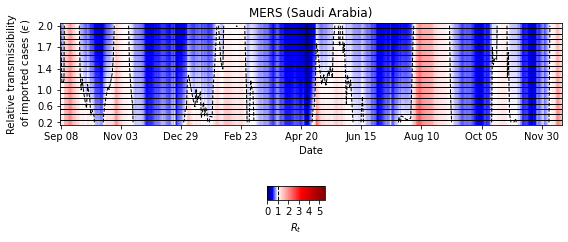

In [6]:
import datetime
import matplotlib.dates
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np


def plot_r_heatmap(region_names, epsilons, R_t_results, first_day, show=True):
    """Plot a heatmap of R_t for different epsilons.

    It assumes that about 20 values of epsilon are provided.

    Parameters
    ----------
    region_names : list of str
        Names of each region (for titles)
    epsilons : list of float
        Value of epsilon
    R_t_results : list of pandas.DataFrame
        For each region, a dataframe containing the inference results for R_t.
        It must contain the columns 'Epsilon', 'Time Points', and 'Mean'.
    first_day : datetime.datetime
        First day of inference results
    show : bool, optional (True)
        Whether or not to plt.show() the figure after it has been generated

    Returns
    -------
    matplotlib.figure.Figure
    """
    num_regions = len(region_names)
    fig = plt.figure(figsize=(8, 5))

    R_t_arrays = []
    num_time_points = []
    for df in R_t_results:
        n = len(df.loc[df['Epsilon'] == 1]['Time Points'])

        # Build an array to hold R values
        X = np.zeros((len(epsilons), n))

        for i, eps in enumerate(epsilons[::-1]):
            X[i, :] = df.loc[df['Epsilon'] == eps]['Mean']

        R_t_arrays.append(X)
        num_time_points.append(n)

    max_R = max([np.max(X) for X in R_t_arrays])
    max_R = 5.5
    max_n = max(num_time_points)

    for k, (name, nt, X) in enumerate(zip(region_names,
                                          num_time_points,
                                          R_t_arrays)):
        ax = fig.add_subplot(1, num_regions, k+1)

        im = ax.imshow(
            X,
            cmap='seismic',
            norm=colors.TwoSlopeNorm(vmin=0, vcenter=1.0, vmax=max_R),
            aspect=nt/max_n * 5)

        ax.contour(X, [1], colors='k', linestyles='--', linewidths=1)

        # Add horizontal lines to divide the epsilons
        for i, eps in enumerate(epsilons):
            ax.axhline(i+0.5, color='k', lw=1)

        e_ticks = [0, 4, 8, 12, 15, 18]
        ax.set_yticks(e_ticks)
        ax.set_yticklabels([epsilons[i] for i in e_ticks[::-1]])
        ax.set_ylabel('Relative transmissibility\n of imported cases ' + r'($ϵ$)')

        x_ticks = list(range(0, nt, 28*2))
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(
            [(first_day + datetime.timedelta(days=i)).strftime('%b %d')
             for i in x_ticks])
        ax.set_xlabel('Date')

        ax.set_title(region_names[k])

    # Add key for R values
    cax = plt.axes([0.47, 0.15, 0.1, 0.04])
    fig.colorbar(im, cax=cax, orientation='horizontal')
    cax.set_xlabel(r'$R_t$')
    
    cax.axvline(1, color='k', ls='--', lw=1)
    
    fig.set_tight_layout(True)

    return fig


fig = plot_r_heatmap(
    ['MERS (Saudi Arabia)',],
    [epsilon_range[0]] + epsilon_range[2:],
    [all_df,],
    datetime.datetime(2014, 8, 11) + datetime.timedelta(days=inference_times[0]-1),
    show=False)

plt.savefig('Figure_S7a.pdf')

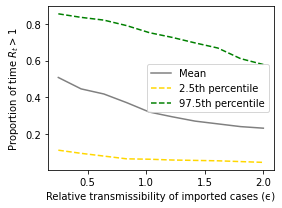

In [7]:
# Run the inference at a finer grid of epsilons
epsilon_range2 = np.linspace(0.25, 2.0, 10)
props = []
props_lower = []
props_upper = []

for epsilon in epsilon_range2:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    prop_R_above_one = intervals['Mean'] > 1
    prop_R_above_one = sum(prop_R_above_one) / len(intervals['Mean'])
    props.append(prop_R_above_one)
    
    prop_R_above_one = intervals['Lower bound CI'] > 1
    prop_R_above_one = sum(prop_R_above_one) / len(intervals['Mean'])
    props_lower.append(prop_R_above_one)   
    
    prop_R_above_one = intervals['Upper bound CI'] > 1
    prop_R_above_one = sum(prop_R_above_one) / len(intervals['Mean'])
    props_upper.append(prop_R_above_one)
    
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(epsilon_range2, props, color='gray', label='Mean')
ax.plot(epsilon_range2, props_lower, color='gold', ls='--', label='2.5th percentile')
ax.plot(epsilon_range2, props_upper, color='green', ls='--', label='97.5th percentile')
ax.set_xlabel('Relative transmissibility of imported cases (ϵ)')
ax.set_ylabel('Proportion of time ' + r'$R_t>1$')
ax.legend()
fig.set_tight_layout(True)

plt.savefig('Figure_S7b.pdf')